In [1]:
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

In [2]:
# identifier = '20220216_no_qual_no_iso'
# # identifier = 'test' # i removed the charge sum requirement

# identifier = '20220216_no_qual_no_iso'

identifier = '20220301_ELReLMIs54_MUReLMIs31_btag77'
# identifier = '20220301_ELReLMIs54_MUReLMIs31_btag77_nochargesum'



original_sig = pd.read_feather('/home/grabanal/minitree/{}_VVZ.arrow'.format(identifier))
original_bkg = pd.read_feather('/home/grabanal/minitree/{}_FULLBG.arrow'.format(identifier))

original_ZZ = pd.read_feather('/home/grabanal/minitree/{}_ZZ.arrow'.format(identifier))
original_WZ = pd.read_feather('/home/grabanal/minitree/{}_WZ.arrow'.format(identifier))
original_Zjets = pd.read_feather('/home/grabanal/minitree/{}_Zjets.arrow'.format(identifier))
original_Zgamma = pd.read_feather('/home/grabanal/minitree/{}_Zgamma.arrow'.format(identifier))
original_ttZ = pd.read_feather('/home/grabanal/minitree/{}_ttZ.arrow'.format(identifier))
original_tZ = pd.read_feather('/home/grabanal/minitree/{}_tZ.arrow'.format(identifier))
original_tWZ = pd.read_feather('/home/grabanal/minitree/{}_tWZ.arrow'.format(identifier))
original_others = pd.read_feather('/home/grabanal/minitree/{}_others.arrow'.format(identifier))

original_oldZjets = pd.read_feather('/home/grabanal/minitree/{}_oldZjets.arrow'.format(identifier))

In [3]:
sig = pd.read_feather('/home/grabanal/minitree/{}_VVZ.arrow'.format(identifier))
bkg = pd.read_feather('/home/grabanal/minitree/{}_FULLBG.arrow'.format(identifier))

ZZ = pd.read_feather('/home/grabanal/minitree/{}_ZZ.arrow'.format(identifier))
WZ = pd.read_feather('/home/grabanal/minitree/{}_WZ.arrow'.format(identifier))
Zjets = pd.read_feather('/home/grabanal/minitree/{}_Zjets.arrow'.format(identifier))
Zgamma = pd.read_feather('/home/grabanal/minitree/{}_Zgamma.arrow'.format(identifier))
ttZ = pd.read_feather('/home/grabanal/minitree/{}_ttZ.arrow'.format(identifier))
tZ = pd.read_feather('/home/grabanal/minitree/{}_tZ.arrow'.format(identifier))
tWZ = pd.read_feather('/home/grabanal/minitree/{}_tWZ.arrow'.format(identifier))
others = pd.read_feather('/home/grabanal/minitree/{}_others.arrow'.format(identifier))

oldZjets = pd.read_feather('/home/grabanal/minitree/{}_oldZjets.arrow'.format(identifier))

In [4]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY

def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error

def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error

def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    S, dS, B, dB = 0, 0, 0, 0
    for sr in [0,1,2]:
        if (sr == 0):
            print("Region 4ℓ-SF-inZ:")
        if (sr == 1):
            print("Region 4ℓ-SF-noZ:")
        if (sr == 2):
            print("Region 4ℓ-DF:")
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        significance, error = significance_and_error(S, dS, B, dB)
        print("--- significance = {:.2f} ± {:.2f} ".format(significance, error))
        m_list.append((significance, error))
        print()
        
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("Total significance in quadrature = {:.2f} ± {:.2f} ".format(significance, error))

In [5]:
print_total_significance_and_error(original_sig, original_bkg)

Region 4ℓ-SF-inZ:
--- S = 10.55 ± 0.07 
--- B = 2129.70 ± 6.30 
--- significance = 0.23 ± 0.00 

Region 4ℓ-SF-noZ:
--- S = 10.79 ± 0.12 
--- B = 630.77 ± 3.74 
--- significance = 0.43 ± 0.00 

Region 4ℓ-DF:
--- S = 12.61 ± 0.15 
--- B = 65.23 ± 4.12 
--- significance = 1.52 ± 0.05 

Total significance in quadrature = 1.59 ± 0.05 


In [6]:
~(3 < 4 < 5)

-2

In [7]:
x = 4
3 < x < 5

True

In [8]:
~(3 < x < 10)

-2

In [9]:
abs(sig.Zlep1_eta)

0         0.271183
1         0.872318
2         0.695911
3         2.441219
4         0.492802
            ...   
122609    1.514092
122610    2.125970
122611    0.326498
122612    1.776091
122613    1.255982
Name: Zlep1_eta, Length: 122614, dtype: float32

In [12]:
def df_filter(df):
    
    temp = df.copy()
    
    temp = temp[(abs(temp.Zlep1_pid) != 11) | ( (abs(temp.Zlep1_eta) < 2.47) & ((abs(temp.Zlep1_eta) < 1.37) | (abs(temp.Zlep1_eta) > 1.52)) )].copy()
    temp = temp[(abs(temp.Zlep1_pid) != 13) |   (abs(temp.Zlep1_eta) < 2.5)].copy()
    
    temp = temp[(abs(temp.Zlep2_pid) != 11) | ( (abs(temp.Zlep2_eta) < 2.47) & ((abs(temp.Zlep2_eta) < 1.37) | (abs(temp.Zlep2_eta) > 1.52)) )].copy()
    temp = temp[(abs(temp.Zlep2_pid) != 13) |   (abs(temp.Zlep2_eta) < 2.5)].copy()
    
    temp = temp[(abs(temp.Wlep1_pid) != 11) | ( (abs(temp.Wlep1_eta) < 2.47) & ((abs(temp.Wlep1_eta) < 1.37) | (abs(temp.Wlep1_eta) > 1.52)) )].copy()
    temp = temp[(abs(temp.Wlep1_pid) != 13) |   (abs(temp.Wlep1_eta) < 2.5)].copy()
    
    temp = temp[(abs(temp.Wlep2_pid) != 11) | ( (abs(temp.Wlep2_eta) < 2.47) & ((abs(temp.Wlep2_eta) < 1.37) | (abs(temp.Wlep2_eta) > 1.52)) )].copy()
    temp = temp[(abs(temp.Wlep2_pid) != 13) |   (abs(temp.Wlep2_eta) < 2.5)].copy()
    
    return temp

In [36]:
print(10.5/2129.7)
print(10.8/630.8)
print(12.6/65.2)

0.004930271869277364
0.01712111604311985
0.19325153374233128


In [37]:
print(9.2/1844.4)
print(9.3/548.2)
print(10.9/57.3)

0.004988072001734981
0.01696461145567311
0.19022687609075045


In [13]:
backgrounds = [ZZ, WZ, Zjets, Zgamma, ttZ, tZ, tWZ, others]
names = ['ZZ', 'WZ', 'Zjets', 'Zgamma', 'ttZ', 'tZ', 'tWZ', 'others']

m_list = []

for SR in [0,1,2]:
    print("In signal region: ", SR)
    
    this_sig = sig[sig.SR == SR].copy()
    
    this_sig = df_filter(this_sig).copy()
#     this_sig = this_sig[this_sig.Zlep1_ambiguous != 1].copy()  
#     this_sig = this_sig[this_sig.Zlep2_ambiguous != 1].copy() 
#     this_sig = this_sig[this_sig.Wlep1_ambiguous != 1].copy() 
#     this_sig = this_sig[this_sig.Wlep1_ambiguous != 1].copy() 

    this_sig_y, this_sig_y_err = yield_and_error(this_sig)
    print("VVZ {:.1f} ± {:.1f} ".format(this_sig_y, this_sig_y_err) )
    
    
    sw  = 0
    sw2 = 0
    for i in range(len(names)):
        this_bkg = backgrounds[i].copy()
        this_bkg = this_bkg[this_bkg.SR == SR]
        
        this_bkg = df_filter(this_bkg).copy()
#         this_bkg = this_bkg[this_bkg.Zlep1_ambiguous != 1].copy()  
#         this_bkg = this_bkg[this_bkg.Zlep2_ambiguous != 1].copy() 
#         this_bkg = this_bkg[this_bkg.Wlep1_ambiguous != 1].copy() 
#         this_bkg = this_bkg[this_bkg.Wlep1_ambiguous != 1].copy() 
        
        if (names[i] == 'Zjets'):
            print(len(this_bkg))
        
        y, y_err = yield_and_error(this_bkg)
        print(names[i], "{:.1f} ± {:.1f} ".format(y, y_err) )
        sw  += y
        sw2 += y_err**2
    
    this_bkg_y = sw
    this_bkg_y_err = np.sqrt(sw2)
    
    print("full BG {:.1f} ± {:.1f} ".format(this_bkg_y, this_bkg_y_err ))
    
    print("----------------------")
    significance, error = significance_and_error(this_sig_y, this_sig_y_err, this_bkg_y, this_bkg_y_err )
    print("significance {:.2f} ± {:.2f} ".format(significance, error))
    m_list.append((significance, error))
    print()

print("----------------------")
print("----------------------")
significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
print("overall {:.2f} ± {:.2f} ".format(significance, error))

In signal region:  0
VVZ 9.2 ± 0.1 
ZZ 1841.3 ± 6.0 
WZ 0.4 ± 0.1 
4
Zjets 0.6 ± 0.5 
Zgamma 0.0 ± 0.0 
ttZ 1.4 ± 0.1 
tZ 0.0 ± 0.0 
tWZ 0.7 ± 0.1 
others 0.1 ± 0.1 
full BG 1844.4 ± 6.0 
----------------------
significance 0.21 ± 0.00 

In signal region:  1
VVZ 9.3 ± 0.1 
ZZ 533.7 ± 2.7 
WZ 2.2 ± 0.3 
10
Zjets 3.0 ± 2.4 
Zgamma 0.1 ± 0.1 
ttZ 5.6 ± 0.2 
tZ 0.1 ± 0.1 
tWZ 2.5 ± 0.2 
others 1.0 ± 0.2 
full BG 548.2 ± 3.6 
----------------------
significance 0.40 ± 0.00 

In signal region:  2
VVZ 10.9 ± 0.1 
ZZ 32.0 ± 0.6 
WZ 2.5 ± 0.3 
34
Zjets 12.3 ± 4.0 
Zgamma 0.3 ± 0.3 
ttZ 6.7 ± 0.2 
tZ 0.1 ± 0.0 
tWZ 2.7 ± 0.2 
others 0.6 ± 0.1 
full BG 57.3 ± 4.1 
----------------------
significance 1.40 ± 0.05 

----------------------
----------------------
overall 1.47 ± 0.05 


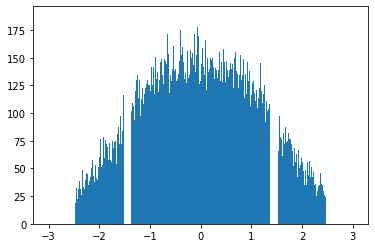

In [34]:
test = df_filter(sig)

plt.hist(test[abs(test.Wlep1_pid) == 11].Wlep1_eta, range=(-3,3), bins=600);

# Application of quality/isolation

In [7]:
len(original_oldZjets)

17385

In [8]:
len(original_Zjets)

15587

In [4]:
def apply_quality_isolation(this_df, Z_quality, i, j, W_quality, k, l):
    
    # ---------- W lepton analysis ----------
    
    # Check quality
    # LL
    if (Z_quality == 0): 
        pass
    # LM
    elif (Z_quality == 1): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_medium == True)] # medium muons
    # LT
    elif (Z_quality == 2): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_tight == True)] # tight muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_tight == True)] # tight muons
    # ML
    elif (Z_quality == 3): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_medium == True)] # medium electrons
    # MM
    elif (Z_quality == 4): 
        this_df = this_df[this_df.Zlep1_medium == True] # medium all
        this_df = this_df[this_df.Zlep2_medium == True] # medium all
    # MT
    elif (Z_quality == 5): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_tight == True)]  # tight muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_tight == True)]  # tight muons
    # TL
    elif (Z_quality == 6): 
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_tight == True)] # tight electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_tight == True)] # tight electrons
    # TM
    elif (Z_quality == 7):
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df.Zlep1_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df.Zlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df.Zlep2_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df.Zlep2_medium == True)] # medium muons
    # TT
    elif (Z_quality == 8):
        this_df = this_df[this_df.Zlep1_tight == True] # tight all
        this_df = this_df[this_df.Zlep2_tight == True] # tight all

    # Isolation loop for electrons, 0 means no iso

    if (i == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Zlep1_pid) == 13) | (this_df['Zlep1_iso_{}'.format(i)] == True)] # iso_i electrons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 13) | (this_df['Zlep2_iso_{}'.format(i)] == True)] # iso_i electrons

    # Isolation loop for muons, 0 means no iso

    if (j == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Zlep1_pid) == 11) | (this_df['Zlep1_iso_{}'.format(j)] == True)] # iso_j muons
        this_df = this_df[(abs(this_df.Zlep2_pid) == 11) | (this_df['Zlep2_iso_{}'.format(j)] == True)] # iso_j muons


    # ---------- W lepton analysis ----------

    # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)

    # Check quality
    # LL
    if (W_quality == 0): 
        pass
    # LM
    elif (W_quality == 1): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_medium == True)] # medium muons
    # LT
    elif (W_quality == 2): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_tight == True)] # tight muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_tight == True)] # tight muons
    # ML
    elif (W_quality == 3): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_medium == True)] # medium electrons
    # MM
    elif (W_quality == 4): 
        this_df = this_df[this_df.Wlep1_medium == True].copy() # medium all
        this_df = this_df[this_df.Wlep2_medium == True].copy() # medium all
    # MT
    elif (W_quality == 5): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_tight == True)]  # tight muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_medium == True)] # medium electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_tight == True)]  # tight muons
    # TL
    elif (W_quality == 6): 
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_tight == True)] # tight electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_tight == True)] # tight electrons
    # TM
    elif (W_quality == 7):
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df.Wlep1_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df.Wlep1_medium == True)] # medium muons 
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df.Wlep2_tight == True)]  # tight electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df.Wlep2_medium == True)] # medium muons
    # TT
    elif (W_quality == 8):
        this_df = this_df[this_df.Wlep1_tight == True] # tight all
        this_df = this_df[this_df.Wlep2_tight == True] # tight all

    # Isolation loop for electrons, 0 means no iso

    if (k == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Wlep1_pid) == 13) | (this_df['Wlep1_iso_{}'.format(k)] == True)] # iso_k W electrons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 13) | (this_df['Wlep2_iso_{}'.format(k)] == True)] # iso_k W electrons

    # Isolation loop for muons, 0 means no iso

    if (l == 0):
        pass
    else:
        this_df = this_df[(abs(this_df.Wlep1_pid) == 11) | (this_df['Wlep1_iso_{}'.format(l)] == True)] # iso_l W muons
        this_df = this_df[(abs(this_df.Wlep2_pid) == 11) | (this_df['Wlep2_iso_{}'.format(l)] == True)] # iso_l W
    
    return this_df

In [11]:
# Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
# i         = 0
# j         = 0
# W_quality = 0
# k         = 4 #e
# l         = 1 #mu

# Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
# i         = 5
# j         = 3
# W_quality = 8
# k         = 4 #e
# l         = 1 #mu

Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
i         = 0
j         = 0
W_quality = 0
k         = 0 #e
l         = 0 #mu

# Z_quality = 0  # Quality loop (LL, LM, LT, ML, MM, MT, TL, TM, TT)
# i         = 0
# j         = 0
# W_quality = 0
# k         = 4 #e
# l         = 1 #mu

sig      = apply_quality_isolation(original_sig,      Z_quality, i, j, W_quality, k, l)
ZZ       = apply_quality_isolation(original_ZZ,       Z_quality, i, j, W_quality, k, l)
WZ       = apply_quality_isolation(original_WZ,       Z_quality, i, j, W_quality, k, l)
oldZjets = apply_quality_isolation(original_oldZjets, Z_quality, i, j, W_quality, k, l)
Zjets    = apply_quality_isolation(original_Zjets,    Z_quality, i, j, W_quality, k, l)
Zgamma   = apply_quality_isolation(original_Zgamma,   Z_quality, i, j, W_quality, k, l)
ttZ      = apply_quality_isolation(original_ttZ,      Z_quality, i, j, W_quality, k, l)
tZ       = apply_quality_isolation(original_tZ,       Z_quality, i, j, W_quality, k, l)
tWZ      = apply_quality_isolation(original_tWZ,      Z_quality, i, j, W_quality, k, l)
others   = apply_quality_isolation(original_others,   Z_quality, i, j, W_quality, k, l)
bkg      = apply_quality_isolation(original_bkg,      Z_quality, i, j, W_quality, k, l)

print("--- Done!")

--- Done!


In [20]:
sum(sig[(sig.Wlep1_iso_1 == False) & (abs(sig.Wlep1_pid) == 13)].wgt)

0

In [21]:
print_total_significance_and_error(sig, bkg)

Region 4ℓ-SF-inZ:
--- S = 10.55 ± 0.07 
--- B = 2129.70 ± 6.30 
--- significance = 0.23 ± 0.00 

Region 4ℓ-SF-noZ:
--- S = 10.79 ± 0.12 
--- B = 630.77 ± 3.74 
--- significance = 0.43 ± 0.00 

Region 4ℓ-DF:
--- S = 12.61 ± 0.15 
--- B = 65.23 ± 4.12 
--- significance = 1.52 ± 0.05 

Total significance in quadrature = 1.59 ± 0.05 


In [27]:
len(oldZjets)

261

In [32]:
len(Zjets[Zjets.SR==2])

89

3.1897719958317636
12.478457608021658
33.633478207783135


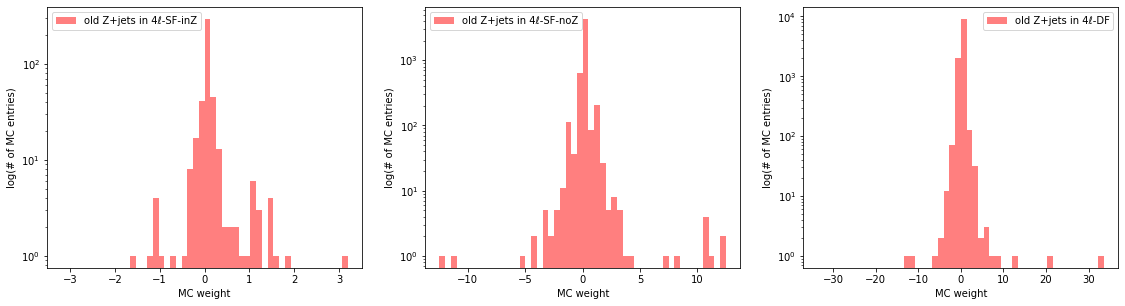

In [96]:
plt.figure(figsize=[3*6.4,1*4.8])

for i in [0, 1, 2]:

    ax = plt.subplot(1, 3, i+1)
    set_1 = oldZjets[oldZjets.SR == i].wgt

    min_x = np.min(set_1)
    max_x = np.max(set_1)
    m = max(abs(min_x), max_x)
    print(m)

    if (i == 0):
        label = 'old Z+jets in 4ℓ-SF-inZ'
    elif (i == 1):
        label = 'old Z+jets in 4ℓ-SF-noZ'
    else:
        label = 'old Z+jets in 4ℓ-DF'
        
    n, bins, _ = plt.hist(set_1, range=(-m, m), bins=50, color='red', alpha=0.5, label=label)
    plt.yscale('log')
    plt.ylabel('log(# of MC entries)')
    plt.xlabel('MC weight')
    plt.legend()

plt.savefig('plots/MCweight_oldZjets_1.pdf')
plt.show()

0.5250530403373633
2.3363787007678356
2.873706662946459


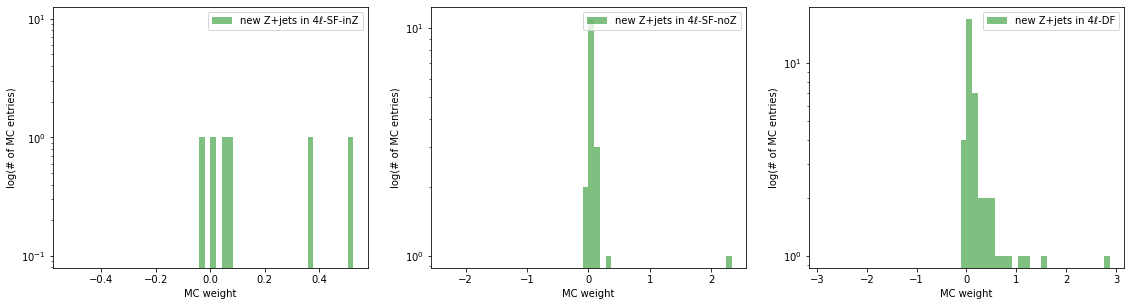

In [12]:
plt.figure(figsize=[3*6.4,1*4.8])

for i in [0, 1, 2]:

    ax = plt.subplot(1, 3, i+1)
    set_1 = Zjets[Zjets.SR == i].wgt

    min_x = np.min(set_1)
    max_x = np.max(set_1)
    m = max(abs(min_x), max_x)
    print(m)
    
    if (i == 0):
        label = 'new Z+jets in 4ℓ-SF-inZ'
    elif (i == 1):
        label = 'new Z+jets in 4ℓ-SF-noZ'
    else:
        label = 'new Z+jets in 4ℓ-DF'

    n, bins, _ = plt.hist(set_1, range=(-m, m), bins=50, color='green', alpha=0.5, label=label)
    plt.yscale('log')
    plt.ylabel('log(# of MC entries)')
    plt.xlabel('MC weight')
    plt.legend()

plt.savefig('plots/MCweight_newZjets_3.pdf')
plt.show()

1.533298090029497
2.3363787007678356
3.1669534777507216


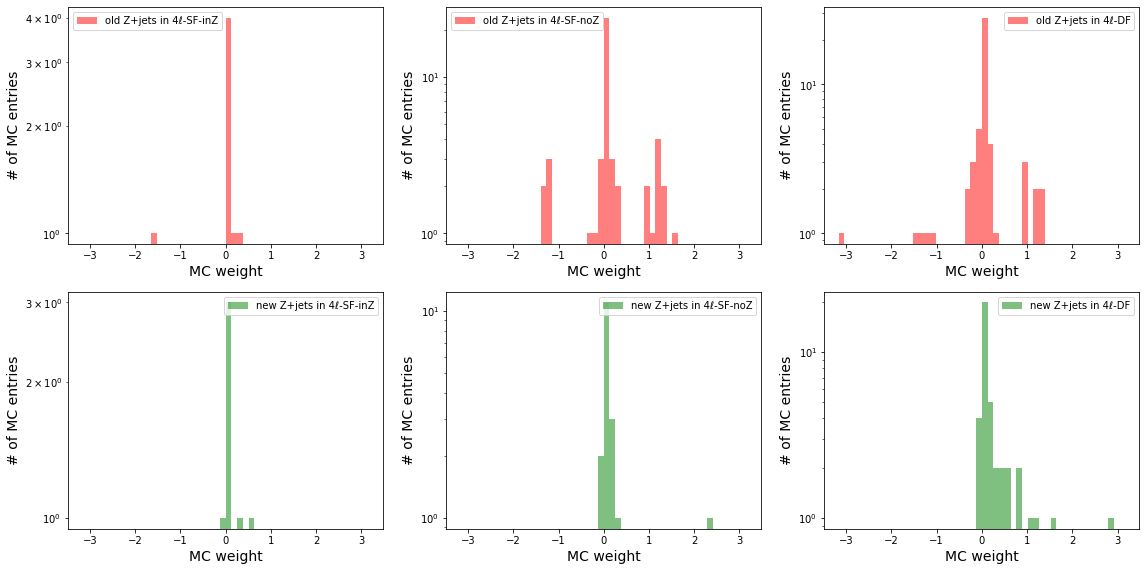

In [13]:
plt.figure(figsize=[3*6.4,2*4.8])

b = 50

m = -1

for i in [0, 1, 2]:

    set_1 = oldZjets[oldZjets.SR == i].wgt
    set_2 = Zjets[Zjets.SR == i].wgt

    min_1 = np.min(set_1)
    max_1 = np.max(set_1)
    min_2 = np.min(set_2)
    max_2 = np.max(set_2)
    m = np.max([m, abs(min_1), max_1, abs(min_2), max_2])
    print(m)


for i in [0, 1, 2]:


    set_1 = oldZjets[oldZjets.SR == i].wgt
    set_2 = Zjets[Zjets.SR == i].wgt

#     min_1 = np.min(set_1)
#     max_1 = np.max(set_1)
#     min_2 = np.min(set_2)
#     max_2 = np.max(set_2)
#     m = np.max([abs(min_1), max_1, abs(min_2), max_2])
#     print(m)
    
    ax = plt.subplot(2, 3, i+1)
    
    if (i == 0):
        label = 'old Z+jets in 4ℓ-SF-inZ'
    elif (i == 1):
        label = 'old Z+jets in 4ℓ-SF-noZ'
    else:
        label = 'old Z+jets in 4ℓ-DF'

    n, bins, _ = plt.hist(set_1, range=(-m, m), bins=b, color='red', alpha=0.5, label=label)
    plt.yscale('log')
    plt.ylabel('# of MC entries', fontsize=14)
    plt.xlabel('MC weight', fontsize=14)
    plt.legend()
    
    ax = plt.subplot(2, 3, i+1+3)
    
    if (i == 0):
        label = 'new Z+jets in 4ℓ-SF-inZ'
    elif (i == 1):
        label = 'new Z+jets in 4ℓ-SF-noZ'
    else:
        label = 'new Z+jets in 4ℓ-DF'

    n, bins, _ = plt.hist(set_2, range=(-m, m), bins=b, color='green', alpha=0.5, label=label)
    plt.yscale('log')
    plt.ylabel('# of MC entries', fontsize=14)
    plt.xlabel('MC weight', fontsize=14)
    plt.legend()
# 
plt.savefig('plots/MC_weight_newZjets_1.pdf')
plt.show()

# Using new Z+jets

In [14]:
len(Zjets)

65

In [15]:
backgrounds = [ZZ, WZ, Zjets, Zgamma, ttZ, tZ, tWZ, others]
names = ['ZZ', 'WZ', 'Zjets', 'Zgamma', 'ttZ', 'tZ', 'tWZ', 'others']

m_list = []

for SR in [0,1,2]:
    print("In signal region: ", SR)
    
    this_sig = sig[sig.SR == SR].copy()
    
    this_sig = this_sig[this_sig.Zlep1_ambiguous != 1].copy()  
    this_sig = this_sig[this_sig.Zlep2_ambiguous != 1].copy() 
    this_sig = this_sig[this_sig.Wlep1_ambiguous != 1].copy() 
    this_sig = this_sig[this_sig.Wlep1_ambiguous != 1].copy() 

    this_sig_y, this_sig_y_err = yield_and_error(this_sig)
    print("VVZ {:.1f} ± {:.1f} ".format(this_sig_y, this_sig_y_err) )
    
    
    sw  = 0
    sw2 = 0
    for i in range(len(names)):
        this_bkg = backgrounds[i].copy()
        this_bkg = this_bkg[this_bkg.SR == SR]
        
        this_bkg = this_bkg[this_bkg.Zlep1_ambiguous != 1].copy()  
        this_bkg = this_bkg[this_bkg.Zlep2_ambiguous != 1].copy() 
        this_bkg = this_bkg[this_bkg.Wlep1_ambiguous != 1].copy() 
        this_bkg = this_bkg[this_bkg.Wlep1_ambiguous != 1].copy() 
        
        if (names[i] == 'Zjets'):
            print(len(this_bkg))
        
        y, y_err = yield_and_error(this_bkg)
        print(names[i], "{:.1f} ± {:.1f} ".format(y, y_err) )
        sw  += y
        sw2 += y_err**2
    
    this_bkg_y = sw
    this_bkg_y_err = np.sqrt(sw2)
    
    print("full BG {:.1f} ± {:.1f} ".format(this_bkg_y, this_bkg_y_err ))
    
    print("----------------------")
    significance, error = significance_and_error(this_sig_y, this_sig_y_err, this_bkg_y, this_bkg_y_err )
    print("significance {:.2f} ± {:.2f} ".format(significance, error))
    m_list.append((significance, error))
    print()

print("----------------------")
print("----------------------")
significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
print("overall {:.2f} ± {:.2f} ".format(significance, error))

In signal region:  0
VVZ 10.3 ± 0.1 
ZZ 2079.7 ± 6.2 
WZ 0.5 ± 0.1 
4
Zjets 0.9 ± 0.6 
Zgamma 0.0 ± 0.0 
ttZ 1.6 ± 0.1 
tZ 0.0 ± 0.0 
tWZ 0.8 ± 0.1 
others 0.1 ± 0.1 
full BG 2083.6 ± 6.3 
----------------------
significance 0.22 ± 0.00 

In signal region:  1
VVZ 10.5 ± 0.1 
ZZ 601.0 ± 2.7 
WZ 3.0 ± 0.3 
12
Zjets 3.3 ± 2.4 
Zgamma 0.4 ± 0.3 
ttZ 6.2 ± 0.2 
tZ 0.1 ± 0.1 
tWZ 2.7 ± 0.3 
others 1.1 ± 0.2 
full BG 617.9 ± 3.7 
----------------------
significance 0.42 ± 0.00 

In signal region:  2
VVZ 12.3 ± 0.2 
ZZ 36.0 ± 0.6 
WZ 3.3 ± 0.3 
40
Zjets 12.6 ± 4.0 
Zgamma 0.3 ± 0.3 
ttZ 7.5 ± 0.2 
tZ 0.1 ± 0.0 
tWZ 3.3 ± 0.3 
others 0.8 ± 0.2 
full BG 63.9 ± 4.1 
----------------------
significance 1.49 ± 0.05 

----------------------
----------------------
overall 1.57 ± 0.05 


# Using old Z+jets samples

In [3]:
len(oldZjets)

NameError: name 'oldZjets' is not defined

In [13]:
backgrounds = [ZZ, WZ, oldZjets, Zgamma, ttZ, tZ, tWZ, others]
names = ['ZZ', 'WZ', 'oldZjets', 'Zgamma', 'ttZ', 'tZ', 'tWZ', 'others']

m_list = []

for SR in [0,1,2]:
    print("In signal region: ", SR)
    
    this_sig = sig[sig.SR == SR].copy()
    this_sig_y, this_sig_y_err = yield_and_error(this_sig)
    print("VVZ {:.1f} ± {:.1f} ".format(this_sig_y, this_sig_y_err) )
    
    
    sw  = 0
    sw2 = 0
    for i in range(len(names)):
        this_bkg = backgrounds[i].copy()
        this_bkg = this_bkg[this_bkg.SR == SR]
        y, y_err = yield_and_error(this_bkg)
        print(names[i], "{:.1f} ± {:.1f} ".format(y, y_err) )
        sw  += y
        sw2 += y_err**2
    
    this_bkg_y = sw
    this_bkg_y_err = np.sqrt(sw2)
    
    print("full BG {:.1f} ± {:.1f} ".format(this_bkg_y, this_bkg_y_err ))
    
    print("----------------------")
    significance, error = significance_and_error(this_sig_y, this_sig_y_err, this_bkg_y, this_bkg_y_err )
    print("significance {:.2f} ± {:.2f} ".format(significance, error))
    m_list.append((significance, error))
    print()

print("----------------------")
print("----------------------")
significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
print("overall {:.2f} ± {:.2f} ".format(significance, error))

In signal region:  0
VVZ 10.5 ± 0.1 
ZZ 2125.5 ± 6.3 
WZ 0.5 ± 0.1 
oldZjets -0.9 ± 1.6 
Zgamma 0.0 ± 0.0 
ttZ 1.7 ± 0.1 
tZ 0.0 ± 0.0 
tWZ 0.8 ± 0.1 
others 0.1 ± 0.1 
full BG 2127.8 ± 6.5 
----------------------
significance 0.23 ± 0.00 

In signal region:  1
VVZ 10.8 ± 0.1 
ZZ 613.4 ± 2.8 
WZ 3.2 ± 0.3 
oldZjets 7.4 ± 4.8 
Zgamma 0.4 ± 0.3 
ttZ 6.4 ± 0.2 
tZ 0.1 ± 0.1 
tWZ 2.8 ± 0.3 
others 1.1 ± 0.2 
full BG 634.8 ± 5.6 
----------------------
significance 0.43 ± 0.00 

In signal region:  2
VVZ 12.6 ± 0.2 
ZZ 36.8 ± 0.6 
WZ 3.4 ± 0.3 
oldZjets 0.0 ± 5.1 
Zgamma 0.3 ± 0.3 
ttZ 7.7 ± 0.2 
tZ 0.1 ± 0.0 
tWZ 3.3 ± 0.3 
others 0.9 ± 0.2 
full BG 52.5 ± 5.2 
----------------------
significance 1.68 ± 0.08 

----------------------
----------------------
overall 1.75 ± 0.08 
